In [4]:
from google.colab import drive, files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!sudo apt-get install unzip
!unzip 'drive/MyDrive/caps_dataset/caps_by_state' -d 'caps_by_state'
!unzip 'drive/MyDrive/caps_dataset/caps_by_color' -d 'caps_by_color'

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn.functional as F

import time
import os
import PIL.Image as Image
from IPython.display import display

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla K80


# Defining train and evaluate functions

In [6]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total * 100
    
    print('Test accuracy:', test_acc)
    
    return test_acc

In [7]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):    
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()        
        
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step()
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

def plot_results(training_accs, training_losses, test_accs):

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(x=range(len(training_accs)), y=training_accs, ax=ax[0])
    sns.lineplot(x=range(len(test_accs)), y=test_accs, ax=ax[0])

    sns.lineplot(x=range(len(training_losses)), y=training_losses, ax=ax[1])

    ax[0].set_title('Train-Test Accuracy')
    ax[1].set_title('Train Loss')

    ax[0].set(xlabel='epoch', ylabel='accuracy')
    ax[1].set(xlabel='epoch', ylabel='loss')

    ax[0].legend(['train', 'test'])
    ax[1].legend(['train'])

    plt.show()

# Loading and Standardizing data with augmentation

In [9]:
# dataset_dir = 'caps_by_color/caps_by_color/'
dataset_dir = 'caps_by_state/caps_by_state/'

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


train_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.RandomRotation(360),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225]) 
])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 4)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 4)

dataset_train_evaluation = ImageFolderWithPaths(root=dataset_dir + "train", transform = test_tfms)
trainevaluationloader = torch.utils.data.DataLoader(dataset_train_evaluation, batch_size = 32, shuffle=False, num_workers = 4)

dataset_test_evaluation = ImageFolderWithPaths(root=dataset_dir + "test", transform = test_tfms)
testevaluationloader = torch.utils.data.DataLoader(dataset_test_evaluation, batch_size = 32, shuffle=False, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# CNN base model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.dropout1 = nn.Dropout(0)
        self.batchnorm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.dropout2 = nn.Dropout(0)
        self.batchnorm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.dropout3 = nn.Dropout(0)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.dropout4 = nn.Dropout(0)
        self.batchnorm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.dropout5 = nn.Dropout(0)
        self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 26)

    def forward(self, x):
        x = self.batchnorm1(self.dropout1(self.pool(F.relu(self.conv1(x)))))
        x = self.batchnorm2(self.dropout2(self.pool(F.relu(self.conv2(x)))))
        x = self.batchnorm3(self.dropout3(self.pool(F.relu(self.conv3(x)))))
        x = self.batchnorm4(self.dropout4(self.pool(F.relu(self.conv4(x)))))
        x = self.batchnorm5(self.dropout5(self.pool(F.relu(self.conv5(x)))))
        
        x = x.view(-1, 64 * 14 * 14)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.fc3(x)
        
        return logits
    
model_ft = Net()

In [ ]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler, 
                                                                  n_epochs=100)

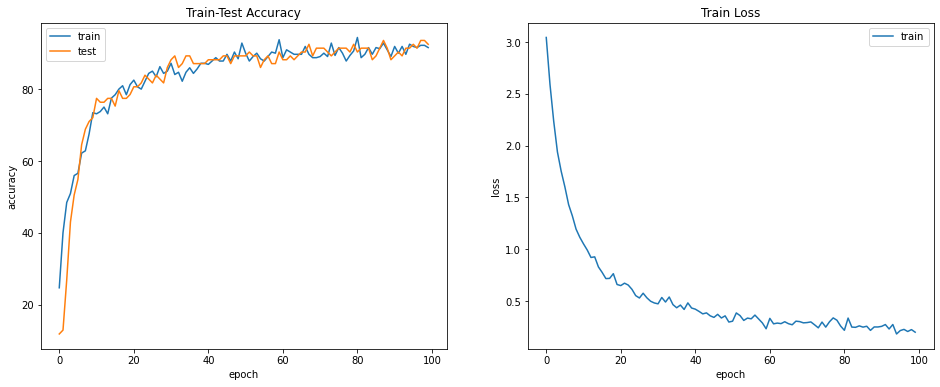

In [ ]:
plot_results(training_accs, training_losses, test_accs)

# Fine-tuning a pre-trained model

In [25]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

In [26]:
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft,
                                                                  criterion,
                                                                  optimizer_ft,
                                                                  lrscheduler,
                                                                  n_epochs=100)

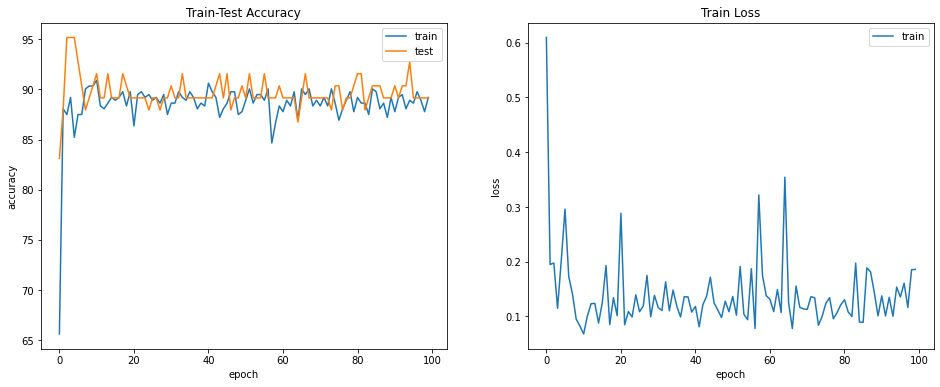

In [28]:
plot_results(training_accs, training_losses, test_accs)

# Visualization of filters and activation map

In [ ]:
# Get the weights in the first conv layer
weights = model_ft.conv1.weight.data
weights = weights.cpu()
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0])
    
print('First convolutional layer')
plt.show()

weights = model_ft.conv2.weight.data
weights = weights.cpu()
w = weights.numpy()

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
idx = 3
img = images[idx].permute(1,2,0).numpy()
import cv2
plt.imshow(img)

weights = model_ft.conv1.weight.data
w = weights.to('cpu').numpy()
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D((img * 255).astype(np.uint8), -1, w[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

# Visualization of wrong predictions

In [ ]:
def show_misclassification(model):
    correct = 0.0
    total = 0.0

    wrong_predictions = list()
    actuals = list()
    wrong_prediction_paths = list()

    with torch.no_grad():
        for dataset in [trainevaluationloader, testevaluationloader]:
            for i, data in enumerate(dataset, 0):
                images, labels, paths = data
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model_ft(images)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                wrong_predictions += predicted[predicted != labels].tolist()
                actuals += labels[predicted != labels].tolist()
                wrong_prediction_paths += np.array(paths)[(predicted != labels).cpu()].tolist()

                # imgs = list(images[predicted != labels].cpu().numpy())
                # images_list += list(map(lambda x: np.einsum('ijk->jki', x), imgs))

    idx_to_class = dict((v, k) for k, v in dataset2.class_to_idx.items())

    for i in range(len(wrong_predictions)):
        print('predicted:', idx_to_class[wrong_predictions[i]])
        print('actual:', idx_to_class[actuals[i]])
        print('path:', wrong_prediction_paths[i])

        image = Image.open(wrong_prediction_paths[i])
        plt.imshow(image)
        plt.show()

    test_acc = correct / total * 100    
    return test_acc

model_ft.eval()
print(show_misclassification(model_ft))